# Final project, part 2 "Analysis of results and correctness of A/B test"

## Description and objectives of the project
Our task is to evaluate the results of the A/B test. We have a dataset with user actions, a technical task and several auxiliary datasets at our disposal.
We need to evaluate the correctness of the test and analyze its results.
The most important stages of verification:
- make sure that there are no intersections with a competing test and there are no users participating in two test groups at the same time;
- check the uniformity of the distribution of users in test groups and the correctness of their formation;
- determine the users participating in the test;

To determine which users participate in the test, you need to:
- check who is participating in the test according to the task;
- next, from the user data, leave only those who came from the target region;
- next, it is necessary to leave out of the received users those who did not get into both groups of the test and those who did not get into group B of the competing test;
- finally, the remaining users need to check whether they have committed events or not. It is necessary to leave only those users who committed the events;

## Technical specification
- Name of the test: recommender_system_test ;
- Groups: A (control), B (new payment funnel);
- Launch Date: 2020-12-07;
- Date of stopping the recruitment of new users: 2020-12-21;
- Stop date: 2021-01-04;
- Expected number of test participants: 15% of new users from the EU region;
- Purpose of the test: testing of changes related to the implementation of an improved recommendation system;
- Expected effect: in 14 days from the moment of registration in the system, users will show an improvement in each metric by at least 5 percentage points:
  - conversions to product card views — product_page event
  - cart views — product_cart
  - purchases — purchase

## Work plan:
1. Open the data file and study the general information
2. We will perform data preprocessing, try to fill in the gaps, check the data for the presence of explicit and implicit duplicates, change the data type if necessary.
3. Let's evaluate the correctness of the test.
4. We will conduct a research analysis of the data.
5. We will evaluate the results of A/B testing.
6. We will write a conclusion about the information received during the study.

## 1. Loading data

In [1]:
# Importing the libraries that we will need in this project
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import math as mth
from scipy import stats as st
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime, timedelta
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 400

In [2]:
# Let's read the data from the csv file into a dataframe, save it to a variable, 
# and study the general information about the table
try:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
except:
    marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

In [3]:
marketing_events.head(10)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [5]:
# Let's read the data from the csv file into a dataframe, save it to a variable, 
# and study the general information about the table
try:
    new_users = pd.read_csv('final_ab_new_users.csv')
except:
    new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')

In [6]:
new_users.head(10)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


In [7]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [8]:
# Let's read the data from the csv file into a dataframe, save it to a variable, 
# and study the general information about the table
try:
    events = pd.read_csv('final_ab_events.csv')
except:
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')

In [9]:
events.head(10)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


In [10]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [11]:
# Let's read the data from the csv file into a dataframe, save it to a variable, 
# and study the general information about the table
try:
    participants = pd.read_csv('final_ab_participants.csv')
except:
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [12]:
participants.head(10)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
7,C46FE336D240A054,A,recommender_system_test
8,92CB588012C10D3D,A,recommender_system_test
9,057AB296296C7FC0,B,recommender_system_test


In [13]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


### Conclusion: at this stage, we have opened the dataset and studied the general information about the source data

## 2. Data preprocessing

**Let's start with the marketing_events table**

#### Let's check how many gaps there are in our table

In [14]:
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

**Conclusion: no gaps were detected.**

#### Let's check how many explicit duplicates there are in our table

In [15]:
marketing_events.duplicated().sum()

0

**Conclusion: no obvious duplicates were found.**

#### Let's check how many implicit duplicates there are in our table

In [16]:
# Let's check for implicit duplicates in the name column
marketing_events['name'].value_counts()

Easter Promo                        1
St. Patric's Day Promo              1
Single's Day Gift Promo             1
Black Friday Ads Campaign           1
International Women's Day Promo     1
St. Valentine's Day Giveaway        1
Chinese New Year Promo              1
Victory Day CIS (May 9th) Event     1
Chinese Moon Festival               1
Dragon Boat Festival Giveaway       1
Labor day (May 1st) Ads Campaign    1
4th of July Promo                   1
Christmas&New Year Promo            1
CIS New Year Gift Lottery           1
Name: name, dtype: int64

**Conclusion: there are no implicit duplicates in the name column.**

In [17]:
# Let's check for implicit duplicates in the start_dt and finish_dt columns
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')
marketing_events['start_dt_year'] = pd.DatetimeIndex(marketing_events['start_dt']).year
marketing_events['finish_dt_year'] = pd.DatetimeIndex(marketing_events['finish_dt']).year
marketing_events

,name,regions,start_dt,finish_dt,start_dt_year,finish_dt_year
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,2020,2021
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,2020,2020
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,2020,2020
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,2020,2020
4,4th of July Promo,N.America,2020-07-04,2020-07-11,2020,2020
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,2020,2020
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07,2020,2020
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,2020,2020
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,2020,2020
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11,2020,2020


**Conclusion: there are no implicit duplicates in the start_dt and finish_dt columns, all values correspond to the task.**

**Let's move on to the new_users table**

#### Let's check how many gaps there are in our table

In [18]:
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

**Conclusion: no omissions were detected.**

#### Let's check how many explicit duplicates there are in our table

In [19]:
new_users.duplicated().sum()

0

**Conclusion: no obvious duplicates were found.**

#### Let's check how many implicit duplicates there are in our table

In [20]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [21]:
# Let's check for which days we have data in the table
new_users.groupby('first_date')['user_id'].nunique()

first_date
2020-12-07    5595
2020-12-08    3239
2020-12-09    2101
2020-12-10    3076
2020-12-11    2390
2020-12-12    3963
2020-12-13    4691
2020-12-14    5654
2020-12-15    3043
2020-12-16    2110
2020-12-17    3048
2020-12-18    3365
2020-12-19    3617
2020-12-20    4288
2020-12-21    6290
2020-12-22    3083
2020-12-23    2180
Name: user_id, dtype: int64

**Conclusion: found users who registered later than December 21, 2020, which does not meet the condition of the task. Since there are many such users, in my opinion it is impossible to delete them. So let's leave them for now.**

In [22]:
# Let's check for implicit duplicates in the region column
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

**Conclusion: no implicit duplicates were found.**

In [23]:
# Let's check for implicit duplicates in the device column
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

**Conclusion: no implicit duplicates were found.**

**Let's move on to the events table**

#### Let's check how many gaps there are in our table

In [24]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [25]:
# Let's calculate the share of passes
pd.DataFrame(events.isna().mean()*100).style.set_precision(1).background_gradient('coolwarm')

,0
user_id,0.0
event_dt,0.0
event_name,0.0
details,85.8


In [26]:
# Let's build a hitmap that will show the number of passes depending on the values of the event_name column
missing_values = events.groupby('event_name').apply(lambda x: x.isna().sum())
missing_values

,user_id,event_dt,event_name,details
event_name,,,,
login,0,0,0,189552
product_cart,0,0,0,62462
product_page,0,0,0,125563
purchase,0,0,0,0


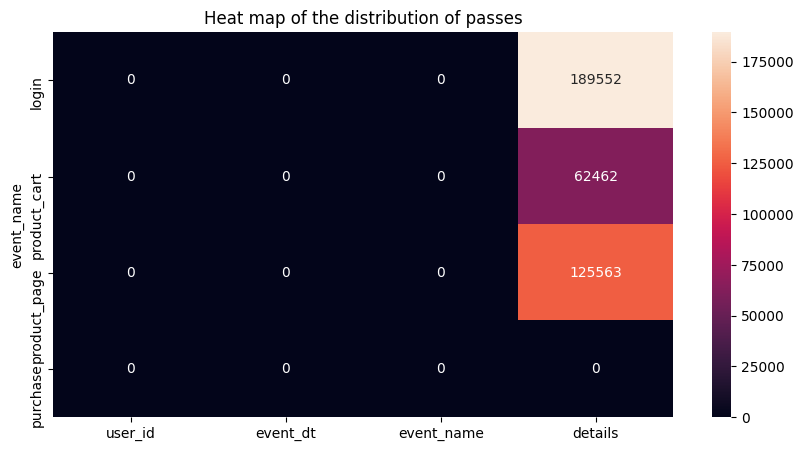

In [121]:
plt.figure(figsize=(10, 5)) # setting the size of the graph
sns.heatmap(missing_values, 
            annot=True, 
            fmt='') # setting the source format
plt.title('Heat map of the distribution of passes') # chart name
plt.show() 

In [28]:
# Now let's count how many times each event occurs in the table
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

**Conclusion: a large number of omissions were detected in the details column. We see that the number of login, product_page, product_cart events completely coincides with the corresponding number of omissions in the details column. In my opinion, we can conclude that the granularity is configured only for the purchase event and this is due to such a large number of omissions in the details column. Accordingly, there is no way to fill in the gaps for the login, product_page, product_cart events and you will have to leave them unchanged.**

#### Let's check how many explicit duplicates there are in our table

In [29]:
events.duplicated().sum()

0

**Conclusion: no obvious duplicates were found.**

#### Let's check how many implicit duplicates there are in our table

In [30]:
# Let's check for implicit duplicates in the event_dt column
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d').dt.date
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07,purchase,99.99
1,7B6452F081F49504,2020-12-07,purchase,9.99
2,9CD9F34546DF254C,2020-12-07,purchase,4.99
3,96F27A054B191457,2020-12-07,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07,purchase,4.99


In [31]:
# Let's check for which days we have data in the table
events.groupby('event_dt')['user_id'].nunique()

event_dt
2020-12-07     5031
2020-12-08     5496
2020-12-09     5227
2020-12-10     6045
2020-12-11     6000
2020-12-12     7562
2020-12-13     9020
2020-12-14    11254
2020-12-15    10083
2020-12-16     9004
2020-12-17     9360
2020-12-18     9883
2020-12-19    10427
2020-12-20    11366
2020-12-21    14044
2020-12-22    12672
2020-12-23    11221
2020-12-24     8361
2020-12-25     7087
2020-12-26     6071
2020-12-27     5334
2020-12-28     4748
2020-12-29     4387
2020-12-30       36
Name: user_id, dtype: int64

**Conclusion: the events from December 7, 2020 to December 30, 2020 are presented, and not until January 4, 2021, as indicated in the task.**

In [32]:
# Let's check for implicit duplicates in the event_name column
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

**Conclusion: no implicit duplicates were found.**

**Let's move on to the participants table**

#### Let's check how many gaps there are in our table

In [33]:
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

**Conclusion: no omissions were detected.**

#### Let's check how many explicit duplicates there are in our table

In [34]:
participants.duplicated().sum()

0

**Conclusion: no obvious duplicates were found.**

#### Let's check how many implicit duplicates there are in our table

In [35]:
# Let's check for implicit duplicates in the ab_test column
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

**Conclusion: it was found that in addition to the recommender_system_test working test, there is another one in the data - interface_eu_test.**

In [36]:
# Let's check for implicit duplicates in the group column
participants['group'].value_counts()

A    9655
B    8613
Name: group, dtype: int64

**Conclusion: no implicit duplicates were found, the values correspond to the task.**

### Conclusion: at this stage, we checked for gaps in the tables, checked the data for duplicates. The following were found:
1. In the new_users table, users were found who registered later than 12/21/2020, which does not meet the condition of the task.
2. a large number of omissions were detected in the events table in the details column, this is due to the fact that the details are configured only for the purchase event. Accordingly, there is no way to fill in the gaps for the login, product_page, product_cart events and it was decided to leave them unchanged.
3. the events table shows events from 7.12.2020 to 30.12.2020, and not until 4.01.2021, as specified in the task.
4. in the participants table, it was found that in addition to the recommender_system_test working test, there is another one in the data - interface_eu_test.

## 3. Assessment of the correctness of the test

#### Checking users participating in the test

##### Let's check the period of user recruitment in the test

In [37]:
# Find the user IDs that participate in the recommender_system_test test
participants_test = participants.query('ab_test == "recommender_system_test"')['user_id']
participants_test.head()

0    D1ABA3E2887B6A73
1    A7A3664BD6242119
2    DABC14FDDFADD29E
3    04988C5DF189632E
4    482F14783456D21B
Name: user_id, dtype: object

In [38]:
# In the new_users table, we leave only users who participate in the recommender_system_test test
# and we build a table by the days of attracting users
period = new_users.loc[new_users['user_id'].isin(participants_test)].\
pivot_table(index='first_date', values='user_id', aggfunc='nunique').reset_index()
period

,first_date,user_id
0,2020-12-07,645
1,2020-12-08,364
2,2020-12-09,258
3,2020-12-10,391
4,2020-12-11,277
5,2020-12-12,489
6,2020-12-13,581
7,2020-12-14,665
8,2020-12-15,359
9,2020-12-16,285


**Conclusion: the user recruitment period corresponds to the task.**

##### Let's check the user registration region

In [39]:
# Let's connect the new_users and participants tables
merged = new_users.merge(participants, on='user_id', how='left')
merged.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,NaN,NaN


In [40]:
# We will leave only the dates of recruitment of new users in the table
merged = merged.query('first_date <= "2020-12-21"')
merged.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,NaN,NaN


In [41]:
# Let's count how many users from Europe participate in the recommender_system_test test
test_from_eu = merged.query('ab_test == "recommender_system_test" and region == "EU"')['user_id'].nunique()

In [42]:
# Let's count the total number of users from Europe
all_from_eu = merged.query('region == "EU"')['user_id'].nunique()

In [43]:
test_from_eu / all_from_eu

0.15

In [44]:
# Let's check which regions the users participating in the test came from
region = merged.query('ab_test == "recommender_system_test"').\
pivot_table(index='region', values='user_id', aggfunc='nunique').reset_index()
region

,region,user_id
0,APAC,72
1,CIS,55
2,EU,6351
3,N.America,223


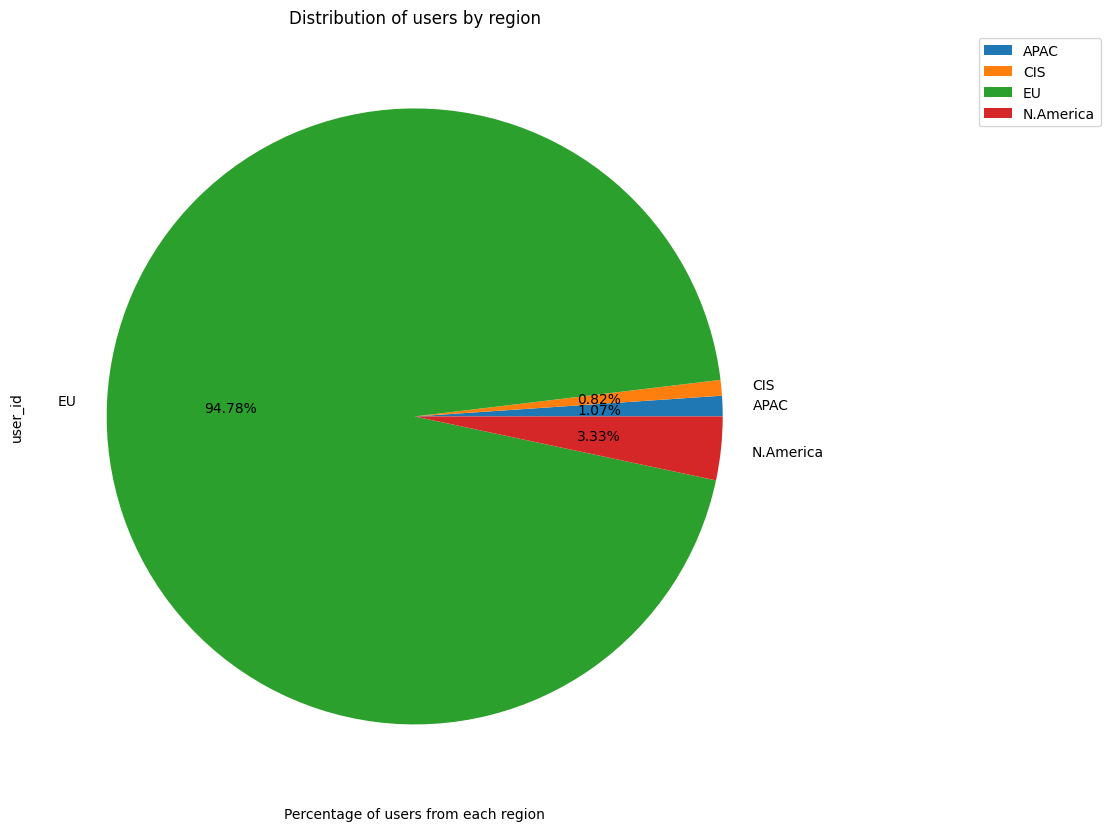

In [122]:
# Visualize the received data
region.plot(x='region', y='user_id', grid=False, 
            figsize=(15, 10), kind='pie', autopct='%.2f%%', 
            title='Distribution of users by region',
           labels=region['region'])
plt.xlabel("Percentage of users from each region")
plt.legend(bbox_to_anchor=(1.4, 1))
plt.show()

**Conclusion: almost all new users participating in the recommender_system_test test came from the target region, their share is 94.8%.
The condition that users from Europe participating in the test must make up 15% of all users from Europe who came from December 7, 2020 to December 21, 2020 is fulfilled.**

##### Let's check the dynamics of the recruitment of users into test groups and the uniformity of the distribution of users into test groups and the correctness of their formation

**As far as I understand, by users participating in the test, here and further it is necessary to understand users with the recommender_system_test attribute, who at the same time came from Europe.**

In [46]:
# In the merged table, we will leave only the data corresponding to the desired test and region
merged_new = merged.query('ab_test == "recommender_system_test" and region == "EU"')
merged_new.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
13,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
21,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
25,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
41,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test


In [47]:
# Creating an array of unique pairs of date values and test groups
dates_groups = merged_new[['first_date','group']].drop_duplicates()
dates_groups = dates_groups.sort_values(by=['first_date','group'])
dates_groups

,first_date,group
0,2020-12-07,A
13,2020-12-07,B
18044,2020-12-08,A
18040,2020-12-08,B
27605,2020-12-09,A
27616,2020-12-09,B
34143,2020-12-10,A
34135,2020-12-10,B
40446,2020-12-11,A
40443,2020-12-11,B


In [48]:
# We get aggregated cumulative data by days
dynamic_participation = dates_groups.apply\
(lambda x: merged_new[np.logical_and(merged_new['first_date'] <= x['first_date'], merged_new['group'] == x['group'])]\
 .agg({'first_date' : 'max', 'group' : 'max', 'user_id' : 'nunique'}), axis=1)\
.sort_values(by=['first_date','group'])
dynamic_participation

,first_date,group,user_id
0,2020-12-07,A,349
13,2020-12-07,B,259
18044,2020-12-08,A,535
18040,2020-12-08,B,408
27605,2020-12-09,A,678
27616,2020-12-09,B,513
34143,2020-12-10,A,867
34135,2020-12-10,B,694
40446,2020-12-11,A,1024
40443,2020-12-11,B,800


In [49]:
# Let's create a dataframe by days in group A
cumulative_A = dynamic_participation[dynamic_participation['group']=='A']

In [50]:
# Let's create a dataframe by days in group B
cumulative_B = dynamic_participation[dynamic_participation['group']=='B']

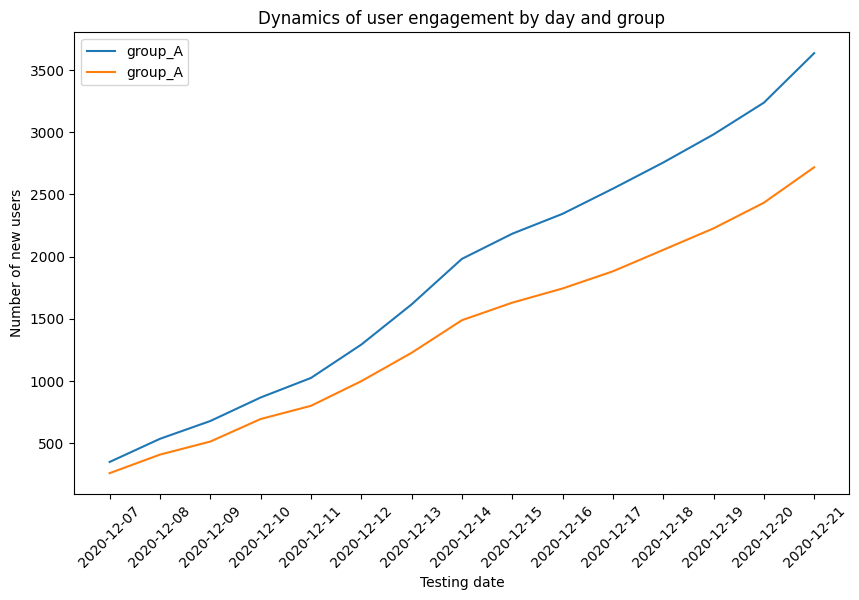

In [123]:
# Let's build a graph that will show the dynamics of attracting users
plt.figure(figsize=(10, 6))
plt.plot(cumulative_A['first_date'], cumulative_A['user_id'], label='group_A')
plt.plot(cumulative_B['first_date'], cumulative_B['user_id'], label='group_A')
plt.legend()
plt.xlabel('Testing date')
plt.ylabel('Number of new users')
plt.title('Dynamics of user engagement by day and group')
plt.xticks(rotation='45')
plt.show()

In [52]:
# Let's calculate the sizes of groups A and B
display(merged_new.query('group == "A"')['user_id'].nunique())
merged_new.query('group == "B"')['user_id'].nunique()

3634

2717

**Conclusion: it can be concluded that the attraction of new users occurred fairly evenly, without a sharp increase in one of the groups.
Nevertheless, group A turned out to be larger, and significantly, respectively, in my opinion, it is impossible to say that the groups were formed correctly.**

#### Let's make sure that there are no intersections of users with a competing test and there are no intersections of users participating in two test groups at the same time.

##### Let's check the correctness of splitting users into groups

In [53]:
# We will get the user IDs that occur in both groups of the test
users_A = merged_new.query('group == "A"')
users_B = merged_new.query('group == "B"')
first_in_second = users_A.loc[users_A['user_id'].isin(users_B['user_id'])]['user_id']
second_in_first = users_B.loc[users_B['user_id'].isin(users_A['user_id'])]['user_id']

In [54]:
# Combine users and remove duplicate values
repeating_users = pd.concat([first_in_second, second_in_first], axis=0).drop_duplicates()

# Let's count the number of users in both groups
repeating_users.shape[0]

0

##### Let's check if there are intersections of users between tests

In [55]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [56]:
# Select the data for the interface_eu_test test
participants_interface = participants.query('ab_test == "interface_eu_test"')

In [57]:
# Get the user IDs that occur in both tables (participants_interface and merged_new)
recommender_in_interface = \
merged_new.loc[merged_new['user_id'].isin(participants_interface['user_id'])]['user_id']

interface_in_recommender = \
participants_interface.loc[participants_interface['user_id'].isin(merged_new['user_id'])]['user_id']


In [58]:
# Combine users and remove duplicate values
repeating_users_2 = pd.concat([recommender_in_interface, interface_in_recommender], axis=0).drop_duplicates()

In [59]:
# Let's count the number of users in both groups
repeating_users_2.shape[0]

1602

**If a user participates in the recommender_system_test test and at the same time is in group A of the interface_eu_test test, then such a user can be left, since his participation in the interface_eu_test test will not affect the recommender_system_test test.** 

**If a user participates in the recommender_system_test test and at the same time is in group B of the interface_eu_test test, then such a user should be deleted, since his participation in the interface_eu_test test will affect the recommender_system_test test.** 

In [60]:
# Get the list of users from the group in the interface_eu_test test, 
# which are in the repeating_users_2 list at the same time
incorrect_users = participants_interface[np.logical_and(participants_interface['user_id'].isin(repeating_users_2),\
participants_interface['group'] == 'B')]['user_id']

# Let's count the number of such users
len(incorrect_users)

783

In [61]:
# Let's calculate the percentage that incorrect users make up of the total number of users participating in the test
len(incorrect_users) / (merged_new['user_id'].nunique())

0.1232876712328767

**Conclusion: in my opinion, such users should be removed from consideration.**

In [62]:
# We will remove such users from the orders table
merged_new = merged_new.loc[~merged_new['user_id'].isin(incorrect_users)]

#### Let's study the data on user activity

##### Let's check whether the dates of the events by the test participants coincide with the dates of the test, according to the terms of reference

In [63]:
# We leave only the events that the test participants committed
correct_events = events.loc[events['user_id'].isin(merged_new['user_id'])]

In [64]:
# Let's check for which days we have data in the table
correct_events.groupby('event_dt')['user_id'].nunique()

event_dt
2020-12-07    264
2020-12-08    232
2020-12-09    288
2020-12-10    245
2020-12-11    223
2020-12-12    238
2020-12-13    200
2020-12-14    508
2020-12-15    492
2020-12-16    529
2020-12-17    558
2020-12-18    585
2020-12-19    658
2020-12-20    702
2020-12-21    915
2020-12-22    580
2020-12-23    461
2020-12-24    384
2020-12-25    298
2020-12-26    264
2020-12-27    262
2020-12-28    224
2020-12-29    202
2020-12-30      2
Name: user_id, dtype: int64

**Conclusion: the test participants committed events from December 7, 2020 to December 30, 2020, and not until January 4, 2021, as indicated in the task. Apparently, January 4, 2021 is the date of stopping the competing test, and not the one under consideration, or users have stopped using the system due to the upcoming New Year holidays.**

##### Let's study user activity

In [65]:
# Let's count the number of users participating in the test
merged_new['user_id'].nunique()

5568

In [66]:
# Let's count the number of users participating in the test and who committed the events
correct_events['user_id'].nunique()

3050

In [67]:
correct_events.head()

,user_id,event_dt,event_name,details
5,831887FE7F2D6CBA,2020-12-07,purchase,4.99
17,3C5DD0288AC4FE23,2020-12-07,purchase,4.99
58,49EA242586C87836,2020-12-07,purchase,99.99
71,2B06EB547B7AAD08,2020-12-07,purchase,4.99
74,A640F31CAC7823A6,2020-12-07,purchase,4.99


In [68]:
# Let's check what events are in the logs, how often they occur
correct_events['event_name'].value_counts()

login           9306
product_page    5740
purchase        2804
product_cart    2714
Name: event_name, dtype: int64

In [69]:
# Let's count how many users participating in the test committed each of these events
users_with_actions = correct_events.pivot_table(index='event_name', values='user_id', aggfunc='nunique')
users_with_actions.sort_values(by='user_id', ascending=False)

,user_id
event_name,
login,3050
product_page,1905
purchase,953
product_cart,900


In [70]:
# Let's calculate the proportion of users who have ever committed an event
users_with_actions['percentage'] = round(100 * (users_with_actions['user_id'] / correct_events['user_id'].nunique()), 2)
users_with_actions.sort_values(by='percentage', ascending=False)

,user_id,percentage
event_name,,
login,3050,100.00
product_page,1905,62.46
purchase,953,31.25
product_cart,900,29.51


**Conclusion: it turns out that 2,518 users participating in the test did not commit the event.**

In [71]:
# We will leave the data only for those users who participated in the test, but did not commit events
merged_no_actions = merged_new.loc[~merged_new['user_id'].isin(correct_events['user_id'])]

In [72]:
merged_no_actions.head()

,user_id,first_date,region,device,group,ab_test
67,16C69ED14DA9F4A8,2020-12-07,EU,PC,B,recommender_system_test
82,2420EA89BB4BB0EA,2020-12-07,EU,iPhone,A,recommender_system_test
88,4D851A41ECF4440F,2020-12-07,EU,Android,B,recommender_system_test
147,8EB0C7622C73BBA3,2020-12-07,EU,Android,A,recommender_system_test
170,CC4AB3D82E6B0C22,2020-12-07,EU,PC,A,recommender_system_test


In [73]:
# Let's count how many of these users got into groups A and B
merged_no_actions_A = merged_no_actions.query('group == "A"')['user_id'].nunique()
merged_no_actions_B = merged_no_actions.query('group == "B"')['user_id'].nunique()

display(merged_no_actions_A)
merged_no_actions_B

916

1602

**Let's try to assess the dynamics of the appearance of users without events**

In [74]:
# Creating an array of unique pairs of event date values and test groups, 
# to then plot the dynamics of the appearance of users without events
no_actions_dates_groups = merged_no_actions[['first_date','group']].drop_duplicates()
no_actions_dates_groups = no_actions_dates_groups.sort_values(by=['first_date','group'])
no_actions_dates_groups

,first_date,group
82,2020-12-07,A
67,2020-12-07,B
18044,2020-12-08,A
18040,2020-12-08,B
27630,2020-12-09,A
27621,2020-12-09,B
34143,2020-12-10,A
34135,2020-12-10,B
40446,2020-12-11,A
40443,2020-12-11,B


In [75]:
# We get aggregated cumulative data by days
no_actions_dynamic_participation = no_actions_dates_groups.apply\
(lambda x: merged_no_actions[np.logical_and(merged_no_actions['first_date'] <= x['first_date'], 
                                            merged_no_actions['group'] == x['group'])]\
 .agg({'first_date' : 'max', 'group' : 'max', 'user_id' : 'nunique'}), axis=1)\
.sort_values(by=['first_date','group'])
no_actions_dynamic_participation

,first_date,group,user_id
82,2020-12-07,A,175
67,2020-12-07,B,70
18044,2020-12-08,A,258
18040,2020-12-08,B,158
27630,2020-12-09,A,311
27621,2020-12-09,B,180
34143,2020-12-10,A,421
34135,2020-12-10,B,312
40446,2020-12-11,A,481
40443,2020-12-11,B,391


In [76]:
# Let's create a dataframe by days in group A
no_actions_cumulative_A = no_actions_dynamic_participation[no_actions_dynamic_participation['group']=='A']

In [77]:
# Let's create a dataframe by days in group B
no_actions_cumulative_B = no_actions_dynamic_participation[no_actions_dynamic_participation['group']=='B']

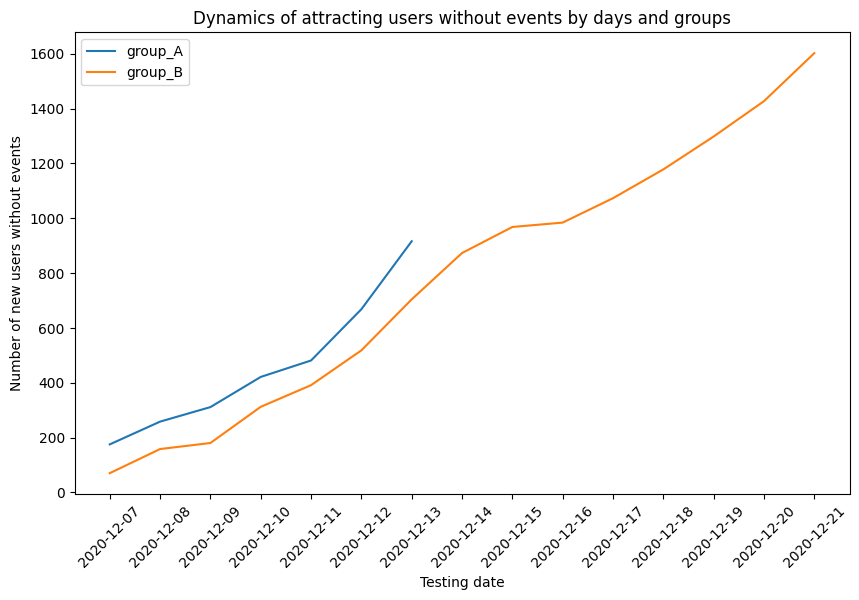

In [124]:
# Let's build a graph that will show the dynamics of attracting users without an event
plt.figure(figsize=(10, 6))
plt.plot(no_actions_cumulative_A['first_date'], no_actions_cumulative_A['user_id'], label='group_A')
plt.plot(no_actions_cumulative_B['first_date'], no_actions_cumulative_B['user_id'], label='group_B')
plt.legend()
plt.xlabel('Testing date')
plt.ylabel('Number of new users without events')
plt.title('Dynamics of attracting users without events by days and groups')
plt.xticks(rotation='45')
plt.show()

**Conclusion: there are 1.75 times more users who did not commit events in group B than similar users from group A. It was also found that the dynamics of the appearance of users without events is completely different - in group A, such users stopped appearing after 13.12.2020, while in group B they appeared during the entire period of recruitment of new users.
In my opinion, this suggests that the distribution of users into groups did not work correctly.** 

**In my opinion, when analyzing the test result, it is necessary to remove users from consideration without events.**

In [79]:
# We will leave the data only for users who participated in the tests and at the same time committed events
merged_correct = merged_new.loc[merged_new['user_id'].isin(correct_events['user_id'])]

##### Calculate the analysis horizon

In [80]:
# Let's connect the merged_correct and correct_events tables
correct_data = merged_correct.merge(correct_events, on='user_id', how='left')
correct_data.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,login,NaN
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07,product_page,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08,product_page,NaN
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10,product_page,NaN


In [81]:
# For each user, we will find the registration date, the events that he committed, the first date for each event
user_lifetime = correct_data.pivot_table(index=['user_id', 'event_name'], 
                                         values=['first_date','event_dt'], 
                                         aggfunc='first').reset_index() 
user_lifetime.head()

,user_id,event_name,event_dt,first_date
0,0010A1C096941592,login,2020-12-17,2020-12-17
1,0010A1C096941592,product_page,2020-12-17,2020-12-17
2,0010A1C096941592,purchase,2020-12-17,2020-12-17
3,00341D8401F0F665,login,2020-12-21,2020-12-21
4,003DF44D7589BBD4,login,2020-12-17,2020-12-17


In [82]:
# Let's calculate the lifetime for each event
user_lifetime['first_date'] = pd.to_datetime(user_lifetime['first_date']).dt.date
user_lifetime['event_dt'] = pd.to_datetime(user_lifetime['event_dt']).dt.date
user_lifetime['lifetime'] = (user_lifetime['event_dt'] - user_lifetime['first_date']).dt.days
user_lifetime.head()

,user_id,event_name,event_dt,first_date,lifetime
0,0010A1C096941592,login,2020-12-17,2020-12-17,0
1,0010A1C096941592,product_page,2020-12-17,2020-12-17,0
2,0010A1C096941592,purchase,2020-12-17,2020-12-17,0
3,00341D8401F0F665,login,2020-12-21,2020-12-21,0
4,003DF44D7589BBD4,login,2020-12-17,2020-12-17,0


In [83]:
# We leave the events that were committed in the first 14 days from the moment of registration
user_lifetime = user_lifetime.query('lifetime < 14')

**Let's check that all the test participants had the opportunity to make events all 14 days from the moment of registration.**

**In my understanding, this means that at least 14 days must pass between the maximum registration date and the test stop date.**

In [84]:
# Let's set the end date of the test and calculate how much time has passed between the maximum registration date and 
# the test stop date
test_stop = datetime(2021, 1, 4).date()
test_stop - user_lifetime['first_date'].max()

datetime.timedelta(days=14)

**Conclusion: the condition is met, although as far as I understand it was originally provided by the source data.**

In [85]:
# Let's estimate when users commit their first events of each type, for each event we will calculate the average lifetime
first_actions = user_lifetime.pivot_table(index='event_name', 
                                         values='lifetime', 
                                         aggfunc='mean').reset_index() 
first_actions

,event_name,lifetime
0,login,0.015743
1,product_cart,0.013333
2,product_page,0.013648
3,purchase,0.011542


**Conclusion: it can be argued that almost all users commit their first events of each type on the day of registration.
Ie, almost all users on the day of registration immediately go through the entire funnel of events.
Also, in my opinion, this confirms the statement that users had the opportunity to make events all 14 days after registration.**

##### We will check the compliance of the text with the requirements of the terms of reference and the possibility of obtaining reliable results of the A/B test, based on the base conversion rate of 50%.

**Let's take the base conversion rate of 50%, the relative difference between the test groups of 5% (according to the task) and upload this data to an online calculator to check what the sample size should be.**

Let's enter the data into the calculator http://www.evanmiller.org/ab-testing/sample-size.html.
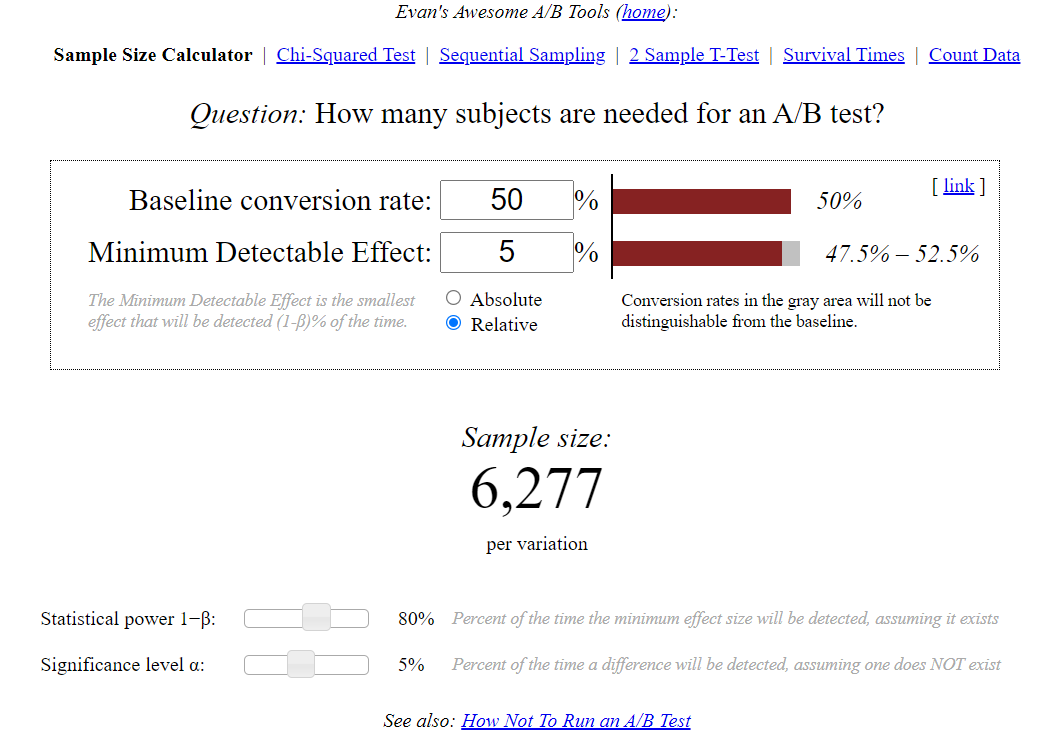

In [86]:
# Let's count how many users participate in the test
correct_data['user_id'].nunique()

3050

**Conclusion: we see that our sample is smaller than the required one. Accordingly, the test does not meet the requirements of the terms of reference.**

### Conclusion: at this stage, we evaluated the correctness of the test. We were able to establish the following:
1. The user recruitment period corresponds to the task.
2. Almost all new users participating in the recommender_system_test test came from the target region, their share is 94.8%. The condition that users from Europe participating in the test should make up 15% of all users from Europe who came from December 7, 2020 to December 21, 2020 is fulfilled.
3. it can be concluded that the attraction of new users occurred fairly evenly, without a sharp increase in one of the groups
4. In the recommender_system_test test, there are no users in both group A and group B.
5. Users were found who participate in both the recommender_system_test test and the interface_eu_test test. From these users, those who are in the group in the interface_eu_test test have been removed.
6. The test participants committed events from December 7, 2020 to December 30, 2020, and not until January 4, 2021, as indicated in the task.
7. 2,518 users participating in the test did not commit the event.
8. There are 1.75 times more users who did not commit an event in group B than similar users from group A. It was also found that the dynamics of the appearance of users without an event is completely different and we can say that the distribution of users into groups worked incorrectly. It was decided to delete the users who participated in the test, but did not commit the event.
9. It can be argued that almost all users commit their first events of each type on the day of registration. Ie, almost all users on the day of registration immediately go through the entire funnel of events.
10. The test does not meet the requirements of the terms of reference, since the sample is less than the required one.

## 4. Exploratory data analysis

#### Let's study the distribution of the number of events per user in the context of test groups

In [87]:
# Let's calculate how many events each user who participated in the test and belongs to group A has committed
actions_A = correct_data.query('group == "A"').pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index() 
actions_A.head()

,user_id,event_name
0,0010A1C096941592,12
1,00341D8401F0F665,2
2,003DF44D7589BBD4,15
3,00505E15A9D81546,5
4,006E3E4E232CE760,6


In [88]:
actions_B = correct_data.query('group == "B"').pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()

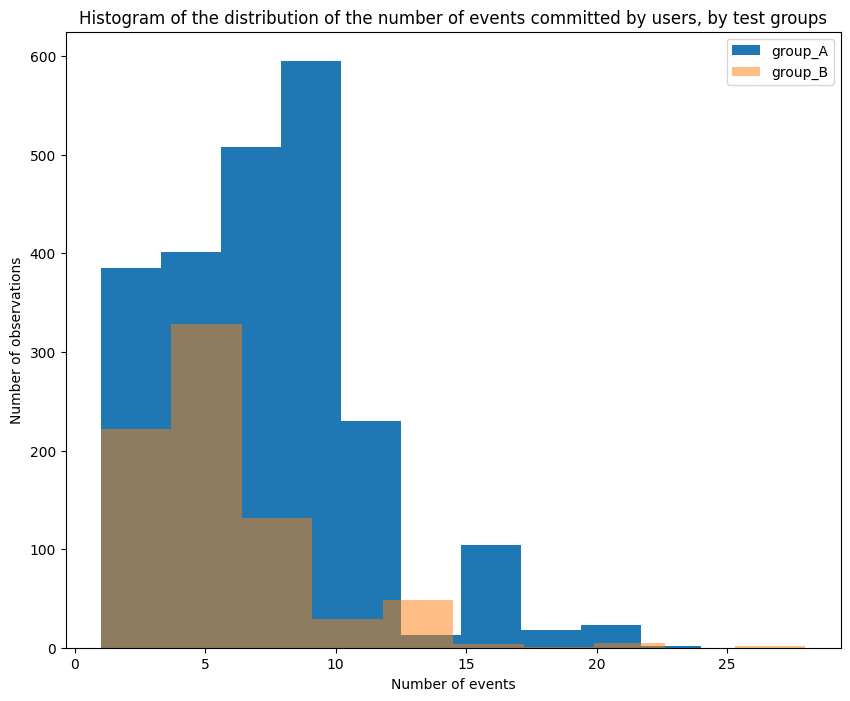

In [125]:
# Let's build histograms of the distribution of the number of events committed by users
plt.figure(figsize = (10, 8))
actions_A['event_name'].hist(bins = 10, grid=False)
actions_B['event_name'].hist(bins = 10, grid=False, alpha = .5)
plt.legend(['group_A', 'group_B'])
plt.xlabel("Number of events")
plt.ylabel("Number of observations")
plt.title('Histogram of the distribution of the number of events committed by users, by test groups')
plt.show();

In [90]:
# For each test group, we will calculate the average value of events committed by one user, then compare these values
display(round(actions_A['event_name'].mean(), 2))
round(actions_B['event_name'].mean(), 2)

7.09

5.72

**To make sure that the values of events committed by one user differ insignificantly in the context of groups, we will conduct a statistical test.**

**Since histograms of distributions have little resemblance to normal distributions, in my opinion, the Mann-Whitney test should be used here.**

**Formulate hypotheses.**

H0 - there are no differences in the average number of events committed by one user between groups A and B. 
H1 - there are differences in the average number of events committed by one user between groups A and B.

In [91]:
sample_A = actions_A['event_name']
sample_B = actions_A['event_name']

(display(len(sample_A)))
len(sample_B)

2279

2279

In [126]:
# Apply the Mann-Whitney criterion and format the p-value by rounding it to three decimal places.
# The significance level will be considered equal to 0.05
alpha = 0.05
results = stats.mannwhitneyu(sample_A, sample_B)[1]
print('p-value:', round(results, 3))
if results < alpha:
    print('We reject the null hypothesis')
else:
    print('It was not possible to reject the null hypothesis')

p-value: 1.0
It was not possible to reject the null hypothesis


**Conclusion: for group A, the magnitude of events committed by one user varies from 6 to 13, for group B from 3 to 6.
A statistical test was also conducted, as a result of which it was revealed that the average values of these values differ slightly.**

#### Let's study the dynamics of the number of events in the test groups by day

In [93]:
# Let's count the number of events by day for each group and the number of unique users
actions_per_day = correct_data.pivot_table(index=['event_dt', 'group'],
                                           values=['event_name', 'user_id'],
                                           aggfunc={'event_name' : 'count', 'user_id' : 'nunique'}).reset_index()

# Let's add a column with the average number of events per user in the context of days to the created table
actions_per_day['action_per_user'] = round(actions_per_day['event_name'] / actions_per_day['user_id'], 4)
actions_per_day

,event_dt,group,event_name,user_id,action_per_user
0,2020-12-07,A,263,122,2.1557
1,2020-12-07,B,315,142,2.2183
2,2020-12-08,A,283,133,2.1278
3,2020-12-08,B,207,99,2.0909
4,2020-12-09,A,331,150,2.2067
5,2020-12-09,B,289,138,2.0942
6,2020-12-10,A,294,136,2.1618
7,2020-12-10,B,218,109,2.0000
8,2020-12-11,A,309,151,2.0464
9,2020-12-11,B,137,72,1.9028


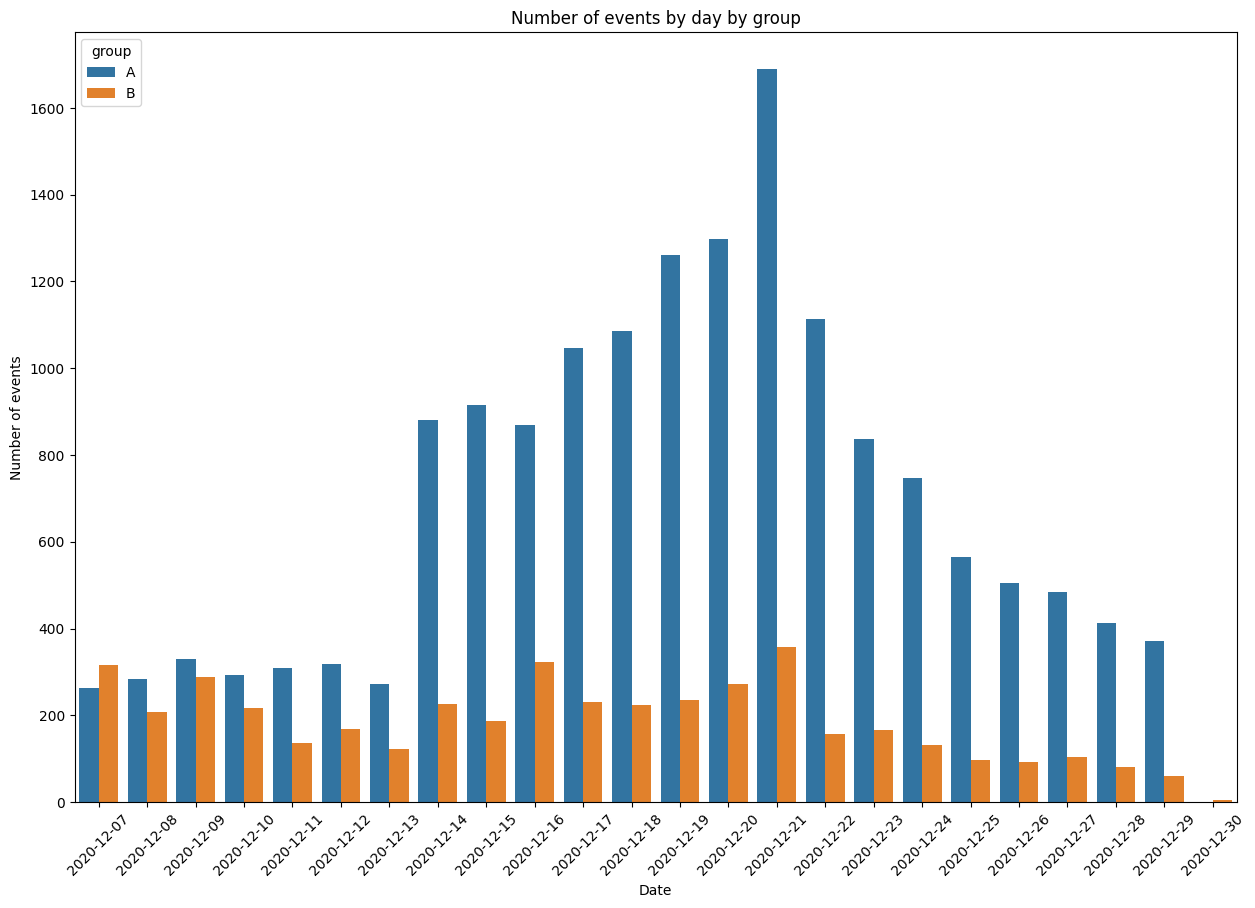

In [127]:
# Let's compare the number of events by day in the context of groups
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.barplot(data=actions_per_day, x="event_dt", y="event_name", hue="group")
plt.xlabel('Date')
plt.ylabel('Number of events')
plt.title('Number of events by day by group')
plt.xticks(rotation='45')
plt.show();

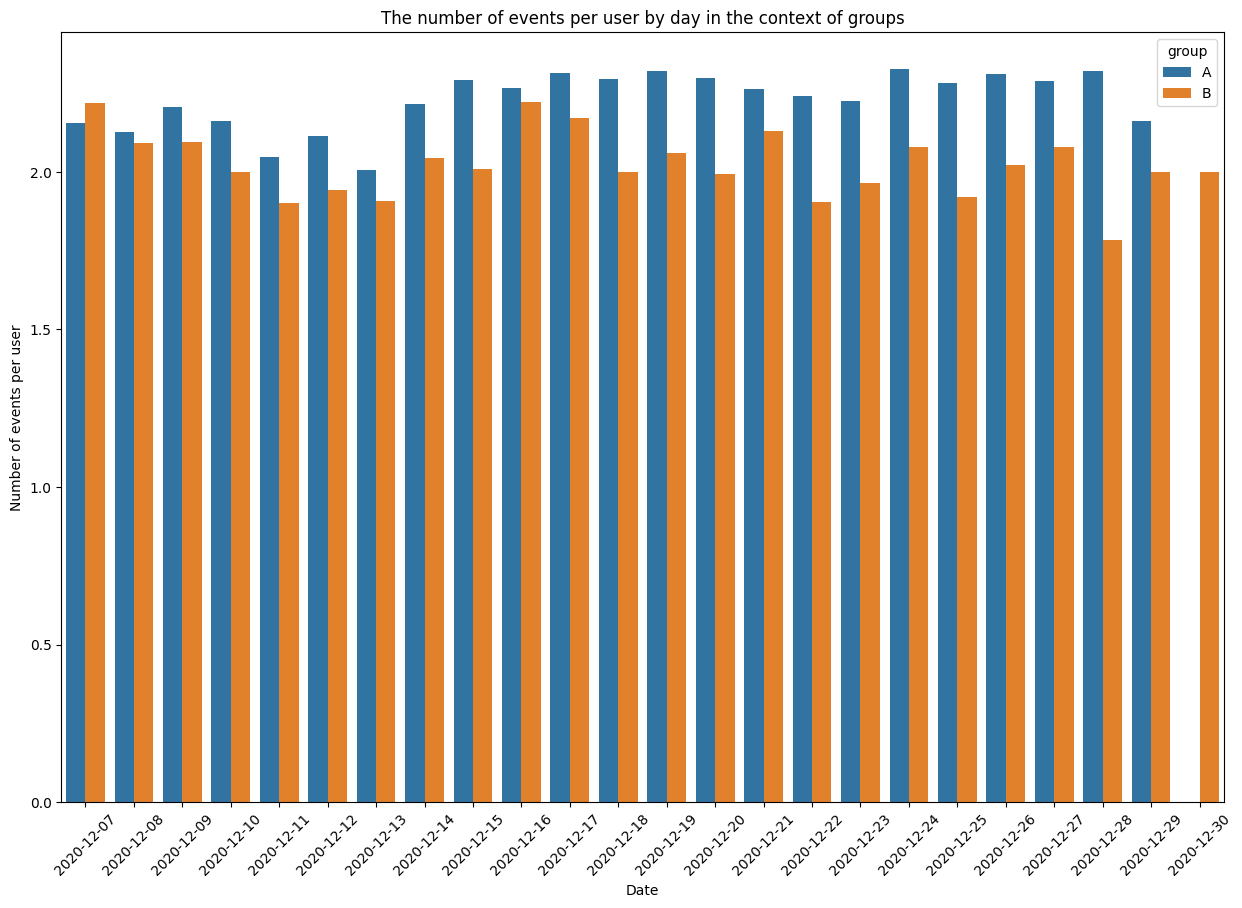

In [128]:
# Let's compare the number of events per user by day in the context of groups
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.barplot(data=actions_per_day, x="event_dt", y="action_per_user", hue="group")
plt.xlabel('Date')
plt.ylabel('Number of events per user')
plt.title('The number of events per user by day in the context of groups')
plt.xticks(rotation='45')
plt.show();

In [96]:
correct_data.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,login,NaN
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07,product_page,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08,product_page,NaN
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10,product_page,NaN


In [97]:
# Creating an array of unique pairs of event date values and test groups, 
# to then plot the dynamics of the number of events in the context of groups
event_dates_groups = correct_data[['event_dt','group']].drop_duplicates()
event_dates_groups = event_dates_groups.sort_values(by=['event_dt','group'])
event_dates_groups

,event_dt,group
0,2020-12-07,A
2,2020-12-07,B
17,2020-12-08,A
3,2020-12-08,B
15,2020-12-09,A
39,2020-12-09,B
235,2020-12-10,A
4,2020-12-10,B
46,2020-12-11,A
72,2020-12-11,B


In [98]:
# We get aggregated cumulative data by days in order to then compare the dynamics of the number of events in the context of groups
dynamic_actions = event_dates_groups.apply\
(lambda x: correct_data[np.logical_and(correct_data['event_dt'] <= x['event_dt'], correct_data['group'] == x['group'])]\
 .agg({'event_dt' : 'max', 'group' : 'max', 'event_name' : 'count'}), axis=1)\
.sort_values(by=['event_dt','group'])
dynamic_actions

,event_dt,group,event_name
0,2020-12-07,A,263
2,2020-12-07,B,315
17,2020-12-08,A,546
3,2020-12-08,B,522
15,2020-12-09,A,877
39,2020-12-09,B,811
235,2020-12-10,A,1171
4,2020-12-10,B,1029
46,2020-12-11,A,1480
72,2020-12-11,B,1166


In [99]:
# Let's create a dataframe by days in group A
cumulative_actions_A = dynamic_actions[dynamic_actions['group']=='A']

# Let's create a dataframe by days in group B
cumulative_actions_B = dynamic_actions[dynamic_actions['group']=='B']

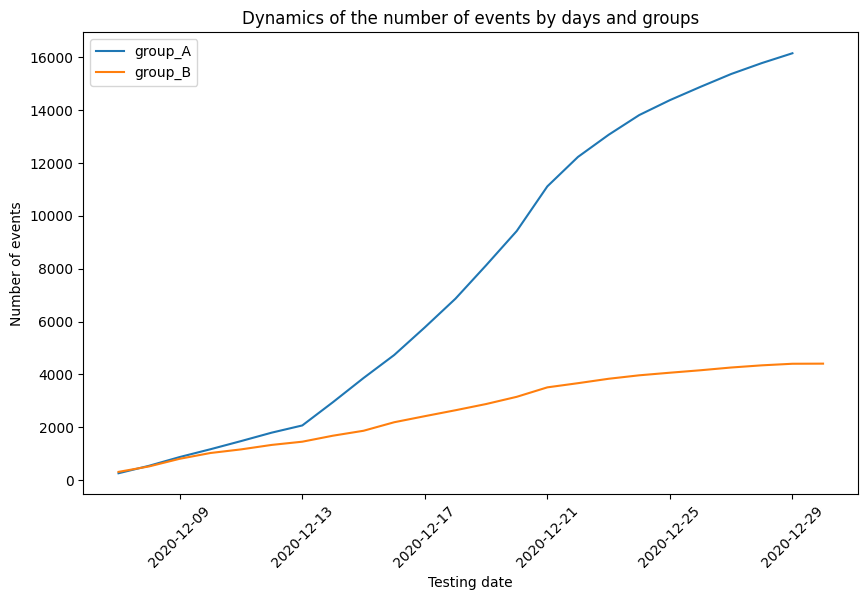

In [129]:
# Let's build a graph that will show the dynamics of the number of events
plt.figure(figsize=(10, 6))
plt.plot(cumulative_actions_A['event_dt'], cumulative_actions_A['event_name'], label='group_A')
plt.plot(cumulative_actions_B['event_dt'], cumulative_actions_B['event_name'], label='group_B')
plt.legend()
plt.xlabel('Testing date')
plt.ylabel('Number of events')
plt.title('Dynamics of the number of events by days and groups')
plt.xticks(rotation='45')
plt.show()

**Conclusion: starting from December 13, 2020, much more events begin to occur in Group A than in group B.**

#### Let's make sure that the time of the test does not coincide with marketing and other activities

In [101]:
# Let's write a function that will check whether the start and start dates of the event fall 
# in the interval between the beginning and the end of the test
# in case of an intersection, the function will return all information about the event
def function(start, finish):
    return marketing_events.\
query('(start_dt <= @finish and start_dt >= @start) or (finish_dt <= @finish and finish_dt >= @start)')

In [102]:
function(start = datetime(2020, 12, 7).date(), finish = datetime(2021, 12, 30).date())

,name,regions,start_dt,finish_dt,start_dt_year,finish_dt_year
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,2020,2021
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07,2020,2021


**Conclusion: The dates of the test overlap with the Christmas&New Year Promo event. At the same time, the gap in the number of events between the test groups began before the start of the Christmas&New Year Promo event.**

**In my opinion, the Christmas&New Year Promo event affected the test, but not dramatically, since after the start of the event there was no sharp increase in the number of events in the test groups.**

#### Let's study the product funnels

**The product funnel looks like this: login - product_page - product_cart- purchase.**

In [103]:
correct_data.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,login,NaN
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07,product_page,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08,product_page,NaN
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10,product_page,NaN


In [104]:
sales_funnel_A = correct_data.query('group == "A"').pivot_table(index='event_name', 
                                                                values='user_id', 
                                                                aggfunc='nunique').reset_index() 
sales_funnel_A

,event_name,user_id
0,login,2279
1,product_cart,686
2,product_page,1476
3,purchase,734


In [105]:
# Let's calculate the proportion of users who have ever committed an event
sales_funnel_A['percentage'] = round\
(100 * (sales_funnel_A['user_id'] / correct_data.query('group == "A"')['user_id'].nunique()), 2)
sales_funnel_A = sales_funnel_A.sort_values(by='percentage', ascending=False)

In [106]:
# Using the funnel of events, we will calculate what proportion of users passes to the next step of the funnel
sales_funnel_A['сonversion_per_step'] = round\
(100 * (sales_funnel_A['user_id'].div(sales_funnel_A['user_id'].shift()).fillna(1.0)), 0)
sales_funnel_A

,event_name,user_id,percentage,сonversion_per_step
0,login,2279,100.00,100.0
2,product_page,1476,64.77,65.0
3,purchase,734,32.21,50.0
1,product_cart,686,30.10,93.0


**We see that the product_cart event was committed by fewer users than the target purchase event. Apparently this suggests that the funnel is not strict and you can buy goods without going into the basket.**
**Therefore, before building a funnel graph, we will add a column with the correct sequence of actions and sort the table by it.**

In [107]:
sequence_of_actions = ['1', '2', '4', '3']
sales_funnel_A['sequence_of_actions'] = sequence_of_actions
sales_funnel_A = sales_funnel_A.sort_values(by='sequence_of_actions')
sales_funnel_A

,event_name,user_id,percentage,сonversion_per_step,sequence_of_actions
0,login,2279,100.00,100.0,1
2,product_page,1476,64.77,65.0,2
1,product_cart,686,30.10,93.0,3
3,purchase,734,32.21,50.0,4


In [130]:
# Visualize the funnel
fig = go.Figure(go.Funnel(
    y = sales_funnel_A['event_name'],
    x = sales_funnel_A['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(title={'text': "Funnel of Group A events"})
fig.show()

In [109]:
# Let's do the same steps for group B
sales_funnel_B = correct_data.query('group == "B"').pivot_table(index='event_name', 
                                                                values='user_id', 
                                                                aggfunc='nunique').reset_index() 

sales_funnel_B['percentage'] = round\
(100 * (sales_funnel_B['user_id'] / correct_data.query('group == "B"')['user_id'].nunique()), 2)
sales_funnel_B = sales_funnel_B.sort_values(by='percentage', ascending=False)


sales_funnel_B['сonversion_per_step'] = round\
(100 * (sales_funnel_B['user_id'].div(sales_funnel_B['user_id'].shift()).fillna(1.0)), 0)

sales_funnel_B['sequence_of_actions'] = sequence_of_actions
sales_funnel_B = sales_funnel_B.sort_values(by='sequence_of_actions')

sales_funnel_B

,event_name,user_id,percentage,сonversion_per_step,sequence_of_actions
0,login,771,100.00,100.0,1
2,product_page,429,55.64,56.0,2
1,product_cart,214,27.76,98.0,3
3,purchase,219,28.40,51.0,4


In [131]:
fig = go.Figure(go.Funnel(
    y = sales_funnel_B['event_name'],
    x = sales_funnel_B['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(title={'text': "Funnel of Group B events"})
fig.show()

**Conclusion: in my opinion, it is impossible to say that group B shows a 10% better conversion rate compared to group A.**

### Conclusion: at this stage, we were engaged in a research analysis of the data. We were able to establish the following:
1. For group A, the magnitude of events committed by one user varies from 6 to 13, for group B from 3 to 6. At the same time, the average values of these values differ slightly and are equal for group A 7, and for group B 6.
2. starting from December 13, 2020 in A lot more events start happening in group A than in group B.
3. The test dates overlap with the Christmas&New Year Promo event. At the same time, the gap in the number of events between the test groups began before the start of the Christmas&New Year Promo event. The Christmas&New Year Promo event affected the test, but not dramatically, since there was no sharp increase in the number of events in the test groups after the start of the event.
4. We cannot say that Group B shows a 10% better conversion rate compared to group A.

## 5. We will evaluate the results of A/B testing

#### Let's check the statistical difference of the fractions by the z-criterion

**We will make null and alternative hypotheses:**

H0: The conversion to the target action product_page of users from group A is equal to the conversion of users from group B.
H1: Conversion to the target action product_page of users from group A is greater than the conversion of users from group B.
Also, to check, we will calculate the conversions of these events and find the difference between them as a percentage.

H0: The conversion to the product_cart target action of users from group A is equal to the conversion of users from group B.
H1: Conversion to the target product_cart action of users from group A is greater than the conversion of users from group B.
Also, to check, we will calculate the conversions of these events and find the difference between them as a percentage.

H0: The conversion to the target purchase action of users from group A is equal to the conversion of users from group B.
H1: Conversion to the target purchase action of users from group A is greater than the conversion of users from group B.
Also, to check, we will calculate the conversions of these events and find the difference between them as a percentage.

##### Let's start with the product_page event

In [111]:
# Let's count the number of users who committed the target event in each of the control groups
success_A = correct_data.query('event_name == "product_page" and group == "A"')['user_id'].nunique()
success_B = correct_data.query('event_name == "product_page" and group == "B"')['user_id'].nunique()

display(success_A)
success_B

1476

429

In [112]:
# Let's calculate the total number of users in each of the control groups
trials_A = correct_data.query('group == "A"')['user_id'].nunique()
trials_B = correct_data.query('group == "B"')['user_id'].nunique()

display(trials_A)
trials_B

2279

771

In [132]:
# Let's test the hypothesis using the built-in z-test
alpha = .05
count = np.array([success_A, success_B])
nobs = np.array([trials_A, trials_B])
stat, p_value = proportions_ztest(count, nobs, alternative='smaller')
print(count, nobs)
print('p-value: ', p_value)
if p_value < alpha:
    print('We reject the null hypothesis: there is a significant difference between the shares')
else:
    print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different')

[734 219] [2279  771]
p-value:  0.9755287018115294
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


In [114]:
# Let's calculate the conversions manually and find out how many percent the conversion of group B 
# is greater than the conversion of group A
conversion_A = success_A / trials_A
conversion_B = success_B / trials_B

conversion_difference = round(conversion_B / conversion_A - 1, 2)
conversion_difference

-0.14

**Conclusion: there is no statistically significant difference between the control groups of users who committed the product_page event. Therefore, it is impossible to say that the conversion of group B is higher. The same statement is confirmed by comparing conversions in percentages - the conversion of group B was 14% worse.**

##### Let's move on to the product_cart event

In [115]:
# Let's count the number of users who committed the target event in each of the control groups
success_A = correct_data.query('event_name == "product_cart" and group == "A"')['user_id'].nunique()
success_B = correct_data.query('event_name == "product_cart" and group == "B"')['user_id'].nunique()

display(success_A)
success_B

686

214

In [133]:
# Let's test the hypothesis using the built-in z-test
alpha = .05
count = np.array([success_A, success_B])
nobs = np.array([trials_A, trials_B])
stat, p_value = proportions_ztest(count, nobs, alternative='smaller')
print(count, nobs)
print('p-value: ', p_value)
if p_value < alpha:
    print('We reject the null hypothesis: there is a significant difference between the shares')
else:
    print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different')

[734 219] [2279  771]
p-value:  0.9755287018115294
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


In [134]:
# Let's calculate the conversions manually and find how many percent the conversion of group B 
# is greater than the conversion of group A
conversion_A = success_A / trials_A
conversion_B = success_B / trials_B

conversion_difference = round(conversion_B / conversion_A - 1, 2)
conversion_difference

-0.12

**Conclusion: there is no statistically significant difference between the control groups of users who committed the product_cart event. Therefore, it is impossible to say that the conversion of group B is higher. The same statement is confirmed by comparing conversions in percentages - the conversion of group B was 8% worse.**

##### Let's move on to the purchase event

In [118]:
# Let's count the number of users who committed the target event in each of the control groups
success_A = correct_data.query('event_name == "purchase" and group == "A"')['user_id'].nunique()
success_B = correct_data.query('event_name == "purchase" and group == "B"')['user_id'].nunique()

display(success_A)
success_B

734

219

In [135]:
# Let's test the hypothesis using the built-in z-test
alpha = .05
count = np.array([success_A, success_B])
nobs = np.array([trials_A, trials_B])
stat, p_value = proportions_ztest(count, nobs, alternative='smaller')
print('p-value: ', p_value)
if p_value < alpha:
    print('We reject the null hypothesis: there is a significant difference between the shares')
else:
    print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different')

p-value:  0.9755287018115294
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


In [120]:
# Let's calculate the conversions manually and find out how many percent the conversion of group B 
# is greater than the conversion of group A
conversion_A = success_A / trials_A
conversion_B = success_B / trials_B

conversion_difference = round(conversion_B / conversion_A - 1, 2)
conversion_difference

-0.12

**Conclusion: there is no statistically significant difference between the control groups of users who committed the purchase event. Therefore, it is impossible to say that the conversion of group B is higher. The same statement is confirmed by comparing conversions in percentages - the conversion of group B was 12% worse.**

### Conclusion: in this section we have tested 3 hypotheses. We were able to establish the following:
1. there is no statistically significant difference between the control groups of users who committed the product_page event.
2. there is no statistically significant difference between the control groups of users who committed the product_cart event.
3. there is no statistically significant difference between the control groups of users who committed the purchase event.
4. considering the above, in my opinion it is impossible to say that the expected effect was achieved in changing the conversion. Rather, on the contrary, Group B showed a weaker result.

## The general conclusion about the correctness of the test.
In my opinion, it is impossible to say that the test was conducted correctly. This was influenced by the following factors:
- Group A initially had many more users than Group B
- it turned out that there are many more users in group B who did not commit any events
- since we decided to delete users who were in group B of a competing test and users who did not commit the event, as a result, we had about 3,000 users left, while 6,277 users were required for the correct conduct of the test.

As a result, we got a situation where there are fewer users than necessary and the test groups are disproportionate. As a result, in group A, users committed much more events, which affected the conversion.
Also, the test coincided with the Christmas&New Year Promo event, respectively, it is impossible to say that users were not subjected to any external influence, and in my opinion this is another reason why it is impossible to say that the test was conducted correctly.

## Recommendations for the test:
1. Conduct a test when there are no marketing activities in the target region.
2. Change the mechanism for distributing users into groups so that groups A and B are more proportionate.
3. Improve the mechanism of attracting users so that it is the target audience that will make events and, accordingly, the number of users without events will decrease.
4. Revise the value of the indicator of the relative difference between the test groups from 5% to 10%, since then a smaller sample will be required for the correct conduct of the test.